In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:52934" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:52957, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:52954, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:52951, threads: 2>})

### Read in training/testing data

In [4]:
#Read in train/test data
train_X = pd.read_pickle('Data/train_test/train_X.pkl')
test_X = pd.read_pickle('Data/train_test/test_X.pkl')
train_y = pd.read_pickle('Data/train_test/train_y.pkl')
test_y = pd.read_pickle('Data/train_test/test_y.pkl')

### K Nearest Neighbor

In [5]:
#Let's try an out of the box KNN
knn = KNeighborsClassifier()
with joblib.parallel_backend('dask'):
    knn.fit(train_X, np.ravel(train_y))
knn.score(test_X, test_y)

0.7758249158249159

Not terrible. We can make some adjustments to the hyperparameters to see if they increases our accuracy. We'll save the score and parameters for review.

In [6]:
#Create dataframe to store scores
knn_deets = pd.DataFrame(knn.get_params(), index=['KNN_OBO'])
knn_deets.insert(0, value=knn.score(test_X, test_y), column='Accuracy')
knn_deets

,Accuracy,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
KNN_OBO,0.775825,auto,30,minkowski,None,None,5,2,uniform


In [7]:
#Let's try using a distance weight version
knn_dist = KNeighborsClassifier(weights='distance')
with joblib.parallel_backend('dask'):
    knn_dist.fit(train_X, np.ravel(train_y))
knn_dist.score(test_X, test_y)

0.7765656565656566

In [8]:
#Store score and metrics
a = knn_dist.get_params()
a['Accuracy'] = knn_dist.score(test_X, test_y)
knn_deets = pd.concat([knn_deets, pd.DataFrame(a, index=['KNN_Dist'])], axis=0, join='outer')
knn_deets

,Accuracy,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
KNN_OBO,0.775825,auto,30,minkowski,None,None,5,2,uniform
KNN_Dist,0.776566,auto,30,minkowski,None,None,5,2,distance


Using class weights does not improve the accuracy, in fact it decreases it. Let's try each of the penalty options for improvement and some different values for C for each. We will need to use the liblinear solver to access the L1 penalty option.

In [9]:
#Run through a loop for hyper parameter tuning 
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    with joblib.parallel_backend('dask'):
        knn.fit(train_X, np.ravel(train_y))
    deets = knn.get_params()
    deets['Accuracy']=knn.score(test_X, test_y)
    knn_deets = pd.concat([knn_deets, pd.DataFrame(deets, index=['KNN_{n}'.format(n=n)])], axis=0, join='outer')

In [10]:
knn_deets

,Accuracy,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
KNN_OBO,0.775825,auto,30,minkowski,None,None,5,2,uniform
KNN_Dist,0.776566,auto,30,minkowski,None,None,5,2,distance
KNN_1,0.755960,auto,30,minkowski,None,None,1,2,distance
KNN_2,0.756498,auto,30,minkowski,None,None,2,2,distance
KNN_3,0.770438,auto,30,minkowski,None,None,3,2,distance
KNN_4,0.773468,auto,30,minkowski,None,None,4,2,distance
KNN_5,0.776566,auto,30,minkowski,None,None,5,2,distance
KNN_6,0.778182,auto,30,minkowski,None,None,6,2,distance
KNN_7,0.779192,auto,30,minkowski,None,None,7,2,distance
KNN_8,0.780471,auto,30,minkowski,None,None,8,2,distance


The adjustments to the penalty and regularization strength show that, though slight, a higher regularization strength increases the accuracy and that the L2 penalty also perfomrs better than L1.

As a final check we will increase the number of iterations the model is allowed to runn through for minimzation and Run through a cross validation check to make sure we are still abel to generalize well. 

In [11]:
#Re-run best model
knn_f = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_f.fit(train_X, np.ravel(train_y))
knn_f.score(test_X, test_y)

0.7816161616161617

In [12]:
#Confirm generalizability using 5-fold cross validation
print(cross_val_score(knn_f, train_X, train_y, cv=5))

[0.78731762 0.77418631 0.77867565 0.77598204 0.7708193 ]


Cross Validation shows a pretty consistent result. We can be confident that this model will generally relativeley well. Let's take a look at a Confusion matrix to see which classes our best Logistic Regression model is doing best with.

<Figure size 2880x576 with 0 Axes>

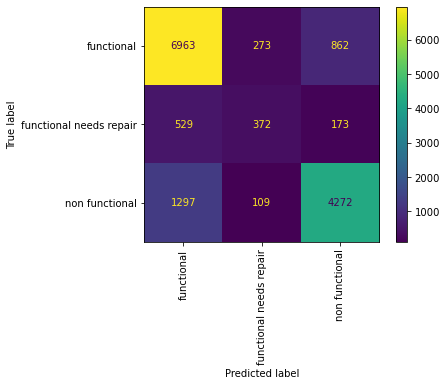

                         precision    recall  f1-score   support

             functional       0.79      0.86      0.82      8098
functional needs repair       0.49      0.35      0.41      1074
         non functional       0.80      0.75      0.78      5678

               accuracy                           0.78     14850
              macro avg       0.70      0.65      0.67     14850
           weighted avg       0.78      0.78      0.78     14850



In [13]:
#Visualize metric by class using confusion matrix and classifiaction report
y_pred = knn_f.predict(test_X)
cm=confusion_matrix(test_y, y_pred, labels=knn_f.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=knn_f.classes_)
plt.figure(figsize=(40,8))
disp.plot()
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
print(classification_report(test_y, y_pred, labels=knn_f.classes_))

We can see that the model performed best on the functional label with non functional just behind it and functional needs repair well below the other two. This makes sense as there are many less cases of functional needs repair so the model doesn't have as much data to learn from.

In [14]:
#Output metrics and parameters for comparison
knn_deets.to_pickle('Data/scores/KNN.pkl')